## Importing Libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data_description_path = 'data_description.txt'

#Load and display data description for reference
with open(data_description_path,'r') as file:
    data_description = file.read()
print('Data Description:\n')
print(data_description[:500],'...\n')

Data Description:

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Uni ...



In [31]:
#Fill missing values
for df in [train, test]:
    num_cols = df.select_dtypes(include = ['float64','int64']).columns
    df[num_cols]= df[num_cols].fillna(df[num_cols].median)
    
    #Categorical columns
    cat_cols = df.select_dtypes(include=['object']).columns
    df[cat_cols] = df[cat_cols].fillna('NA')

## Feature Engineetring and Solution

In [32]:
#Create meaningful features based on domain knowledge
def add_features(df):
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF']+ df['2ndFlrSF']
    df['TotalBathrooms'] = (df['FullBath']+df['HalfBath']*0.5 + df['BsmtFullBath']+df['BsmtHalfBath']*0.5)
    df['TotalPorchSF'] = (df['OpenPorchSF']+df['EnclosedPorch']+df['3SsnPorch']+df['ScreenPorch'])
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
add_features(train)

In [43]:
#test make all calulative columns from object to int
test[['TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']] = test[['TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']].apply(pd.to_numeric, errors='coerce')
test = test.fillna(0).astype({'TotalBsmtSF': 'int', 'BsmtFullBath': 'int', 'BsmtHalfBath': 'int'})

In [44]:
add_features(test)

## Data Visualization

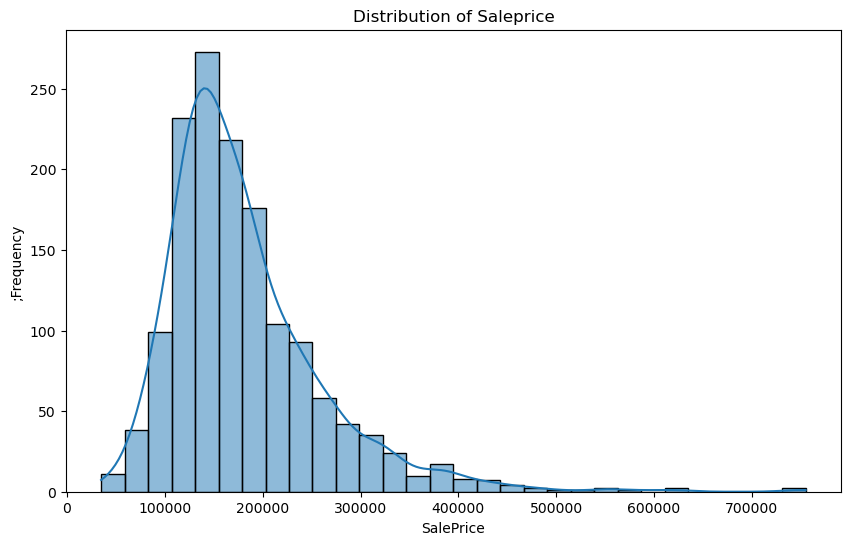

In [46]:
plt.figure(figsize = (10,6))
sns.histplot(train['SalePrice'],kde = True, bins=30)
plt.title('Distribution of Saleprice')
plt.xlabel('SalePrice')
plt.ylabel(';Frequency')
plt.show()

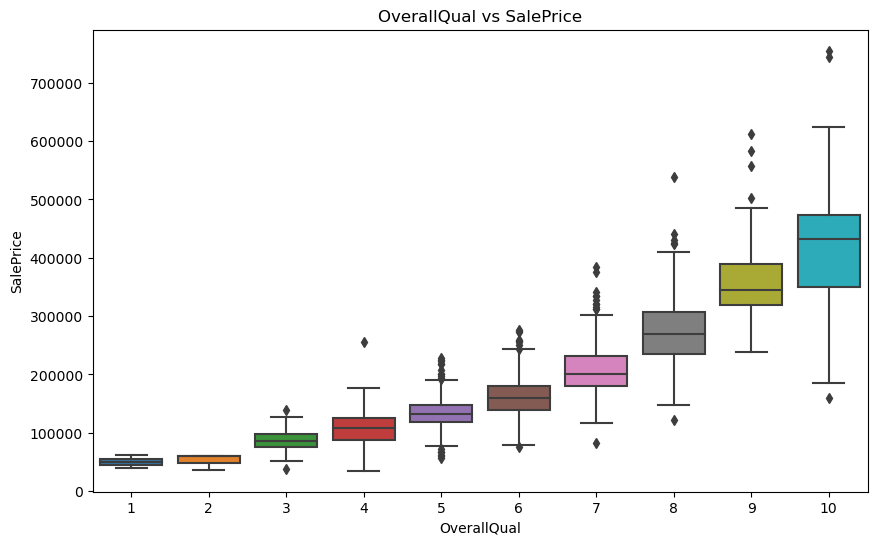

In [47]:
# Boxplot: OverallQual vs SalePrice
plt.figure(figsize=(10, 6))
sns.boxplot(x=train['OverallQual'], y=train['SalePrice'])
plt.title('OverallQual vs SalePrice')
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.show()

## Preprocessing

In [58]:
#Separate target variable and features
y = train['SalePrice']
X= train.drop(columns = ['SalePrice','Id'])
test_ids = test['Id']
test.drop(columns = ['Id'], inplace = True)

In [68]:
#Idemtify categorical and numerical columns
categorical_cols = X.select_dtypes(include = ['object']).columns
numerical_cols = X.select_dtypes(include=['float64','int64']).columns

#define preprocessors
preprocessor = ColumnTransformer(
    transformers = [
        ('num',MinMaxScaler(),numerical_cols),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_cols)])

## Train model with Random Forest

In [70]:
print(X.dtypes)

MSSubClass          int64
MSZoning           object
LotFrontage        object
LotArea             int64
Street             object
                   ...   
TotalSF             int64
TotalBathrooms    float64
TotalPorchSF        int64
Age                 int64
RemodAge            int64
Length: 79, dtype: object


In [72]:
X[categorical_cols] = X[categorical_cols].astype(str)

In [73]:
rf_model = Pipeline(steps=[('preprocessor',preprocessor),('model',RandomForestRegressor(random_state =42 ))])

#split the traing data
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.2, random_state=42)

#fit the model
rf_model.fit(X_train,y_train)

#Evaluate the model
val_preds = rf_model.predict(X_val)
rf_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f'Random Forest RMSE: {rf_rmse}')

Random Forest RMSE: 29214.140482570074


In [87]:
#train Gradient Boosting(XGBoost)

xgb_model = Pipeline(steps = [('preprocessor',preprocessor),('model',XGBRegressor(random_State = 42))])
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val , xgb_preds))
print(f'XGBoost RMSE : {xgb_rmse}')

C:\Users\sumit\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:35:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "random_State" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost RMSE : 27224.843541399776


## Model Optimization (Optional Hyperparmeter Tunin)

In [88]:
param_grid = {
    'model__n_estimators':[100,200],
    'model__max_depth':[3,5],
}
gs = GridSearchCV(rf_model,param_grid, cv=3, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)
print(f'Best Params: {gs.best_params_}')

Best Params: {'model__max_depth': 5, 'model__n_estimators': 200}


In [89]:
print(gs.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbv...
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object'))])),
                ('model',
                 RandomForestRegressor(max_depth=5, n_estimators=200,
                                       random_state=42))])


## Predications and Submission

In [91]:
final_preds = gs.best_estimator_.predict(test)
submission = pd.DataFrame({'Id': test_ids, 'SalePrice': final_preds})
submission.to_csv('submission.csv', index=False)